Uncertainty Sampling for Responsibilities
===

Identifying journals for additional annotation based on the 'confidence' of the classifier.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../../annotation_data")

In [3]:
from responsibility import *
from utils import *

In [18]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.metrics
import os
import scipy

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl

In [6]:
vw_working_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw"
all_preds_filepath = os.path.join(vw_working_dir, "vw_all_preds.pkl")
df = pd.read_pickle(all_preds_filepath)
len(df)

157389

In [7]:
df[[col for col in df.columns if col.endswith("_pred")]].head()

,behavior_changes_pred,compliance_pred,coordinating_support_pred,financial_management_pred,giving_back_pred,sharing_medical_info_pred
0,0.566514,0.325545,0.519111,0.575837,0.596610,0.354442
1,0.514408,0.090461,0.481237,0.517510,0.540775,0.057784
2,0.218780,0.138589,0.190549,0.213944,0.249954,0.131028
3,0.290441,0.112008,0.306833,0.287974,0.309798,0.095549
4,0.363212,0.115526,0.195098,0.396739,0.401722,0.103328


In [33]:
# We make copies to let us create new columns as-needed
a_df = df[df.is_annotated].copy()
un_df = df[~df.is_annotated].copy()
y_pred = un_df[[resp_label + "_pred_label" for resp_label in high_irr_responsibility_labels]].values
y_score_raw = un_df[[resp_label + "_pred" for resp_label in high_irr_responsibility_labels]].values
y_score = 1 - np.clip(y_score_raw, 0, 1)
assert y_pred.shape == y_score.shape
y_true = a_df[[resp_label + "_label" for resp_label in high_irr_responsibility_labels]].values
y_pred.shape, y_true.shape

((155498, 6), (1891, 6))

In [34]:
def compute_max_margin_prediction_uncertainty(pred, threshold=0.5):
    # See "Active Learning with Multi-Label SVM Classification" eq. 2
    pos_pred = pred[pred > 0.5]
    neg_pred = pred[pred < 0.5]
    if len(pos_pred) == 0 or len(neg_pred) == 0:
        # All or none of the labels were assigned using this threshold!
        # Thus we say the margin is the distance to the threshold
        return threshold - np.max(pred) if len(pos_pred) == 0 else np.min(pred) - threshold
    min_pos_pred = np.min(pos_pred)
    max_neg_pred = np.max(neg_pred)
    sep_margin = min_pos_pred - max_neg_pred
    return sep_margin

## Cardinality Sampling

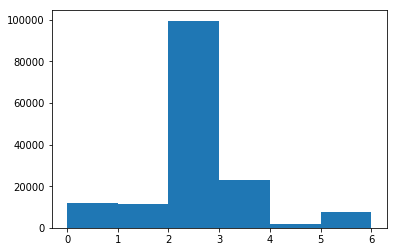

In [35]:
pred_cardinality = np.apply_along_axis(lambda row: np.sum(row), 1, y_pred)
un_df['cardinality'] = pred_cardinality

plt.hist(pred_cardinality, bins=6)
plt.show()

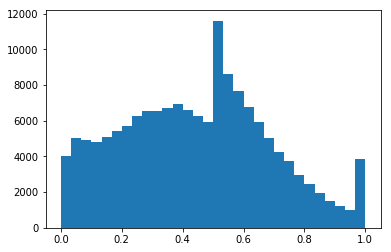

In [37]:
# also compute and insert entropy measure
pred_mmpu = np.apply_along_axis(lambda row: compute_max_margin_prediction_uncertainty(row), 1, y_score)
un_df['max_margin'] = pred_mmpu
assert np.isclose(np.ptp(pred_mmpu), 1)

plt.hist(pred_mmpu, range=(0,1), bins=30)
plt.show()

In [39]:
un_df.sort_values(by=['cardinality', 'max_margin'], ascending=False, inplace=True)

In [42]:
display_cols = ['site_id', 'journal_oid', 'cardinality', 'max_margin'] + [resp_label + "_pred_label" for resp_label in high_irr_responsibility_labels]
un_df[display_cols].head()

,site_id,journal_oid,cardinality,max_margin,coordinating_support_pred_label,sharing_medical_info_pred_label,compliance_pred_label,financial_management_pred_label,giving_back_pred_label,behavior_changes_pred_label
85862,829111,523d20accb16b4a80ea80789,6,0.368323,1,1,1,1,1,1
91559,839384,52a24586ac7ee95c507d4602,6,0.368323,1,1,1,1,1,1
145932,715191,5272895da689b4cf36c142a5,6,0.368323,1,1,1,1,1,1
146903,719363,525f036d0dad103249c4a209,6,0.311400,1,1,1,1,1,1
146898,719363,523083d2a589b4222550fc57,6,0.311013,1,1,1,1,1,1


In [45]:
num_to_display = 20
for i in range(len(un_df)):
    if i >= num_to_display:
        break
    r = un_df.iloc[i]
    print(f"{r.site_id}#{r.journal_oid}  {get_webclient_url(r.site_id, r.journal_oid)}")

829111#523d20accb16b4a80ea80789  http://127.0.0.1:5000/siteId/829111#523d20accb16b4a80ea80789
839384#52a24586ac7ee95c507d4602  http://127.0.0.1:5000/siteId/839384#52a24586ac7ee95c507d4602
715191#5272895da689b4cf36c142a5  http://127.0.0.1:5000/siteId/715191#5272895da689b4cf36c142a5
719363#525f036d0dad103249c4a209  http://127.0.0.1:5000/siteId/719363#525f036d0dad103249c4a209
719363#523083d2a589b4222550fc57  http://127.0.0.1:5000/siteId/719363#523083d2a589b4222550fc57
892521#53ac30464db921e00e87bbff  http://127.0.0.1:5000/siteId/892521#53ac30464db921e00e87bbff
918879#54439d38ab28b9d3390b9a09  http://127.0.0.1:5000/siteId/918879#54439d38ab28b9d3390b9a09
682979#51cb9949af3d79cf69ab511d  http://127.0.0.1:5000/siteId/682979#51cb9949af3d79cf69ab511d
672895#51be8b186ca004f2350029c0  http://127.0.0.1:5000/siteId/672895#51be8b186ca004f2350029c0
672895#51bf42f76ca0047c2503854e  http://127.0.0.1:5000/siteId/672895#51bf42f76ca0047c2503854e
672895#51c15fd56ca004fb43037f74  http://127.0.0.1:5000/siteI

In [52]:
# Select journals believed to have the "Health Behavior Changes" responsibility
# Using cardinality as a tie-breaker
un_df.sort_values(by=['behavior_changes_pred', 'cardinality'], ascending=[True, False], inplace=True)
num_to_display = 30
for i in range(len(un_df)):
    if i >= num_to_display:
        break
    r = un_df.iloc[i]
    print(f"{r.site_id}#{r.journal_oid}  {get_webclient_url(r.site_id, r.journal_oid)}")

871242#538dd608ab28b9710a7e6b4f  http://127.0.0.1:5000/siteId/871242#538dd608ab28b9710a7e6b4f
557731#51bfd30a6ca004374009f9fd  http://127.0.0.1:5000/siteId/557731#51bfd30a6ca004374009f9fd
557731#51c065136ca0046b2808daf2  http://127.0.0.1:5000/siteId/557731#51c065136ca0046b2808daf2
865589#531955a2ac7ee9f011898b04  http://127.0.0.1:5000/siteId/865589#531955a2ac7ee9f011898b04
829111#523d20accb16b4a80ea80789  http://127.0.0.1:5000/siteId/829111#523d20accb16b4a80ea80789
839384#52a24586ac7ee95c507d4602  http://127.0.0.1:5000/siteId/839384#52a24586ac7ee95c507d4602
715191#5272895da689b4cf36c142a5  http://127.0.0.1:5000/siteId/715191#5272895da689b4cf36c142a5
719363#523083d2a589b4222550fc57  http://127.0.0.1:5000/siteId/719363#523083d2a589b4222550fc57
719363#525f036d0dad103249c4a209  http://127.0.0.1:5000/siteId/719363#525f036d0dad103249c4a209
174656#51be264d6ca004ac6e008aed  http://127.0.0.1:5000/siteId/174656#51be264d6ca004ac6e008aed
845372#52928908a589b49268cdae64  http://127.0.0.1:5000/siteI

## Annotated Journals List

In [61]:
annotated_journals = """
# List of uncertainty-sampled journals

# Max cardinality, high uncertainty
829111#523d20accb16b4a80ea80789  http://127.0.0.1:5000/siteId/829111#523d20accb16b4a80ea80789
839384#52a24586ac7ee95c507d4602  http://127.0.0.1:5000/siteId/839384#52a24586ac7ee95c507d4602
715191#5272895da689b4cf36c142a5  http://127.0.0.1:5000/siteId/715191#5272895da689b4cf36c142a5
719363#525f036d0dad103249c4a209  http://127.0.0.1:5000/siteId/719363#525f036d0dad103249c4a209

# Annotated by Drew, updates likely to contain Health Behavior Changes
871242#538dd608ab28b9710a7e6b4f  http://127.0.0.1:5000/siteId/871242#538dd608ab28b9710a7e6b4f
557731#51bfd30a6ca004374009f9fd  http://127.0.0.1:5000/siteId/557731#51bfd30a6ca004374009f9fd
557731#51c065136ca0046b2808daf2  http://127.0.0.1:5000/siteId/557731#51c065136ca0046b2808daf2
865589#531955a2ac7ee9f011898b04  http://127.0.0.1:5000/siteId/865589#531955a2ac7ee9f011898b04
829111#523d20accb16b4a80ea80789  http://127.0.0.1:5000/siteId/829111#523d20accb16b4a80ea80789
839384#52a24586ac7ee95c507d4602  http://127.0.0.1:5000/siteId/839384#52a24586ac7ee95c507d4602
715191#5272895da689b4cf36c142a5  http://127.0.0.1:5000/siteId/715191#5272895da689b4cf36c142a5
719363#523083d2a589b4222550fc57  http://127.0.0.1:5000/siteId/719363#523083d2a589b4222550fc57
719363#525f036d0dad103249c4a209  http://127.0.0.1:5000/siteId/719363#525f036d0dad103249c4a209
174656#51be264d6ca004ac6e008aed  http://127.0.0.1:5000/siteId/174656#51be264d6ca004ac6e008aed
845372#52928908a589b49268cdae64  http://127.0.0.1:5000/siteId/845372#52928908a589b49268cdae64
161781#51db24d3cb16b45d40fd3350  http://127.0.0.1:5000/siteId/161781#51db24d3cb16b45d40fd3350
174656#51be264d6ca004ac6e0088bd  http://127.0.0.1:5000/siteId/174656#51be264d6ca004ac6e0088bd
916963#5536cfbaac7ee9cc0207f613  http://127.0.0.1:5000/siteId/916963#5536cfbaac7ee9cc0207f613
174656#51be264d6ca004ac6e008785  http://127.0.0.1:5000/siteId/174656#51be264d6ca004ac6e008785
208751#51be2e5c6ca004e3090085f2  http://127.0.0.1:5000/siteId/208751#51be2e5c6ca004e3090085f2
123594#51be185b6ca004a34200ad0b  http://127.0.0.1:5000/siteId/123594#51be185b6ca004a34200ad0b
174656#51be264d6ca004ac6e0084ab  http://127.0.0.1:5000/siteId/174656#51be264d6ca004ac6e0084ab
194643#51be2ad96ca004407d00bdb7  http://127.0.0.1:5000/siteId/194643#51be2ad96ca004407d00bdb7
243954#51be34fe6ca004581f005fd2  http://127.0.0.1:5000/siteId/243954#51be34fe6ca004581f005fd2
124934#51be18bd6ca004be4300850e  http://127.0.0.1:5000/siteId/124934#51be18bd6ca004be4300850e
208309#51be2e486ca004ae0900a7e9  http://127.0.0.1:5000/siteId/208309#51be2e486ca004ae0900a7e9
449128#5302783aac7ee9cd080c7706  http://127.0.0.1:5000/siteId/449128#5302783aac7ee9cd080c7706
169907#51be254b6ca004846b009bcd  http://127.0.0.1:5000/siteId/169907#51be254b6ca004846b009bcd
672895#51be8b186ca004f2350029c0  http://127.0.0.1:5000/siteId/672895#51be8b186ca004f2350029c0
672895#51bf42f76ca0047c2503854e  http://127.0.0.1:5000/siteId/672895#51bf42f76ca0047c2503854e
672895#51c15fd56ca004fb43037f74  http://127.0.0.1:5000/siteId/672895#51c15fd56ca004fb43037f74
694979#51d4ece4a689b4960dacf7b1  http://127.0.0.1:5000/siteId/694979#51d4ece4a689b4960dacf7b1
714287#51e2d8b4cb16b4437d45ea9c  http://127.0.0.1:5000/siteId/714287#51e2d8b4cb16b4437d45ea9c
728169#51c160b16ca004b947017f1f  http://127.0.0.1:5000/siteId/728169#51c160b16ca004b947017f1f

"""

active_learned_journals = [line.strip().split()[0]
                           for line in annotated_journals.split("\n") 
                           if line.strip() != "" and not line.startswith("#")]
active_learned_journals = [(int(line.split("#")[0]), line.split("#")[1]) for line in active_learned_journals]
unique_sites = set([site_id for site_id, _ in active_learned_journals])

active_learned_sites_filename = "uncertainty_sampled_responsibility_journals.txt"
active_learned_sites_filepath = os.path.join("/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/active_learning", active_learned_sites_filename)
with open(active_learned_sites_filepath, 'w') as outfile:
    outfile.write("\n".join([str(site_id) + "#" + journal_oid for site_id, journal_oid in active_learned_journals]))
print("Finished updating responsibility journals file.")
print(f"{len(active_learned_journals)} journals from {len(unique_sites)} sites have been uncertainty-sampled for responsibilities.")

Finished updating responsibility journals file.
34 journals from 23 sites have been uncertainty-sampled for responsibilities.


In [58]:
len(a_df), len(set(a_df.site_id))

(1891, 82)